In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F
from tqdm import tqdm
import pandas as pd
from numpy.random import Generator
import random
from scipy.stats import ks_2samp

In [2]:
config = {
    'nbase': 1000,
    'neca': 5000,
    'nwaypoints': 20,
    'iterations': 300,
    'prn': 20,
}

# Toy Datasets

In [3]:
# For Base cohort
age = 45
lab1 = 3.4
lab2 = 5000
pcond1 = 0.3
pcat1 = 0.5

mean = [age, lab1, lab2]
cov = [[14, 3, 100], 
       [3, 2, 50],
       [100, 50, 25000]]


np.random.seed(42)
x = np.random.multivariate_normal(mean, cov, config['nbase'])
x[x< 0] = 0

lab3 = np.random.beta(1, 2, size=config['nbase'])
x = np.concatenate((x, lab3.reshape(config['nbase'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['nbase']).reshape(config['nbase'], -1)
x = np.concatenate((x, cat1), axis=1)

data_base = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [4]:
# For External cohort
age = 50
lab1 = 5.5
lab2 = 4800
pcond1 = 0.5
pcat1 = 0.7
factor = 1.5

mean = [age, lab1, lab2]
cov = [[20, 5, 150], 
       [5, 4, 100],
       [150, 100, 55000]]


x = np.random.multivariate_normal(mean, cov, config['neca'])
x[x< 0] = 0

lab3 = factor*np.random.beta(1, 2, size=config['neca'])
x = np.concatenate((x, lab3.reshape(config['neca'], -1)), axis=1)

cond1 = np.random.binomial(1, pcond1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cond1), axis=1)

cat1 = np.random.binomial(3, pcat1, size=config['neca']).reshape(config['neca'], -1)
x = np.concatenate((x, cat1), axis=1)

data_eca = pd.DataFrame(x, columns=['age', 'lab1', 'lab2', 'lab3', 'cond1', 'cat1'])

In [5]:
# Define Cohen's d: Standardized Mean Difference
def cohensd(d1, d2):
    num = np.mean(d1) - np.mean(d2)
    den = np.sqrt((np.std(d1) ** 2 + np.std(d2) ** 2) / 2)
    cohens_d = num / den
    return cohens_d

In [6]:
# Plot data distribution
def plot_dist(data1, data2, col, ax=None):
    if not ax:
        _, ax = plt.subplots(1,1)
        
    ax.hist(data1[col], density=True, fill='black', histtype='stepfilled', 
             edgecolor='black', bins= 20, linewidth=1.2, label=data1.name)
    ax.hist(data2[col], density=True, bins= 20, fill='blue', histtype='stepfilled',
             edgecolor='blue', linewidth=1.2, label=data2.name, alpha=0.7)
    ax.legend(loc='best')
    ax.set_title(col)
    return 

In [7]:
def scotts_factor(n):
    """Compute Scott's factor.
    Returns
    -------
    s : float
        Scott's factor.
    """
    return np.power(n, -1./5)

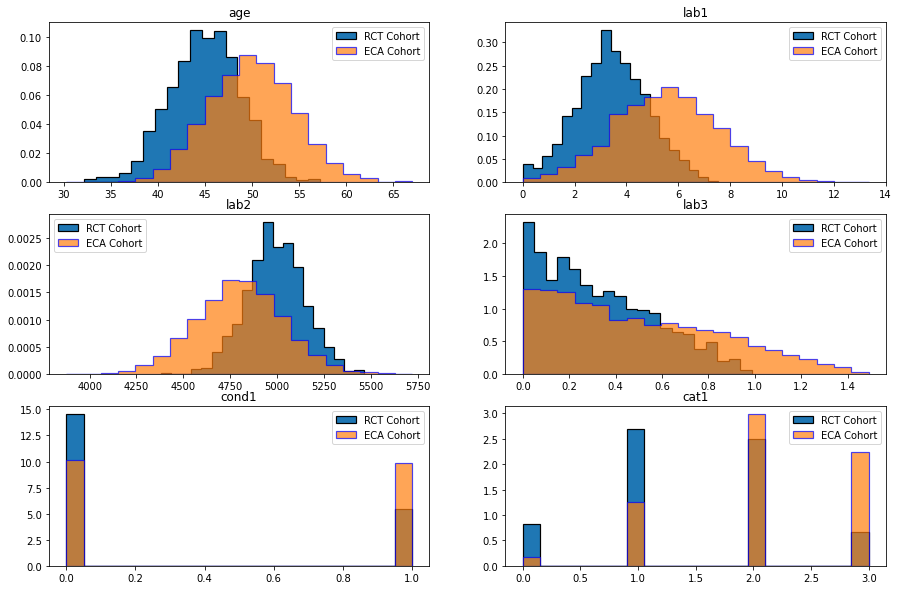

In [8]:
# View the Starting distribution

_, ax = plt.subplots(3,2, figsize=(15, 10))

data_base.name = 'RCT Cohort'
data_eca.name = 'ECA Cohort'
plot_dist(data_base, data_eca, 'age', ax[0][0])
plot_dist(data_base, data_eca, 'lab1', ax[0][1])
plot_dist(data_base, data_eca, 'lab2', ax[1][0])
plot_dist(data_base, data_eca, 'lab3', ax[1][1])
plot_dist(data_base, data_eca, 'cond1', ax[2][0])
plot_dist(data_base, data_eca, 'cat1', ax[2][1])

In [9]:
# # To be REMOVED
# waypoints = np.atleast_2d(np.array([9, 9.5, 10, 10.5, 11])).T

# torch.manual_seed(42)
# X = torch.normal(10, 1, size=(5000, 1))
# Y = torch.normal(14, 2.5, size=(5000, 1))

# Xdf = pd.DataFrame(X.numpy(), columns=['a'])
# Ydf = pd.DataFrame(Y.numpy(), columns=['b'])

In [10]:
# Precompute parameters required for KDE estimation
dist_density, waypoints, barwidth, kde_base = {}, {}, {}, {}

for c in data_base.columns:
    b = max(data_base[c].max(), data_eca[c].max())
    a = min(data_base[c].min(), data_eca[c].min())
    waypoints[c] = torch.tensor(np.linspace(a, b, config['nwaypoints']))
    barwidth[c] = torch.diff(waypoints[c])[0]
            
v, b = [], []
for c in data_base.columns:
    v.append(waypoints[c])
    b.append(barwidth[c])

waypoints = torch.stack(v,1)
barwidths = torch.stack(b,0).unsqueeze(0).repeat(config['nwaypoints'], 1)

In [11]:
import torch
from torch.distributions import Normal
from torch.distributions.distribution import Distribution

class GaussianKDE(Distribution):
    def __init__(self, X, bw, weights=None):
        """
        X : tensor (n, d)
          `n` points with `d` dimensions to which KDE will be fit
        bw : numeric
          bandwidth for Gaussian kernel
        """
        self.X = X
        self.ncols = X.shape[1]
        self.bw = bw
        self.n = X.shape[0]
        self.mvn = Normal(loc=torch.zeros(1), scale=1)
        
        if weights is not None:
            self.weights = weights/sum(weights)
        else:
            self.weights = (1/len(X))*torch.ones(len(X))
        self.neff = 1/sum(self.weights**2)

    def __call__(self, Y, X=None):
        """Returns the kernel density estimates of each point in `Y`.

        Parameters
        ----------
        Y : tensor (m, d)
          `m` points with `d` dimensions for which the probability density will
          be calculated
        X : tensor (n, d), optional
          `n` points with `d` dimensions to which KDE will be fit. Provided to
          allow batch calculations in `log_prob`. By default, `X` is None and
          all points used to initialize KernelDensityEstimator are included.


        Returns
        -------
        probs : tensor (m)
          probability densities for each of the queried points in `Y`
        """
           
        if X is not None:
            self.X = X
        
        bw = self.bw
#         import pdb; pdb.set_trace()
        logprob = (self.mvn.log_prob((self.X.unsqueeze(1) - Y) / bw))
        
        
#         probs = ((1/bw) * torch.exp(logprob).sum(dim=0))/self.n
            
        # experiment
        b1 = self.weights.repeat(Y.shape[0],1).T
        b22 = b1.unsqueeze(2).repeat(1, 1, self.ncols)
        w = (b22 * torch.exp(logprob))/sum(self.weights)
        probs = (1/bw)* w.sum(dim=0)
        
        return probs

In [12]:
class KDEoptim(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, X, Y, wp):
        
        super().__init__()
        base, eca = [], []
        for i in X.columns:
            base.append(torch.tensor(X[i]))
            eca.append(torch.tensor(Y[i]))
            
        X = torch.stack(base, dim=1)
        Y = torch.stack(eca, dim=1)
        
        weights = torch.ones(Y.shape[0], requires_grad=True)/len(Y)  
        self.weights = nn.Parameter(weights)
        self.waypoints = wp
        
        self.Y = Y
        self.kde_target = GaussianKDE(X, bw=0.2)(self.waypoints)
        
    def forward(self):
        """
        forward fn
        """
        kde2_estimated = GaussianKDE(self.Y, bw=0.2, 
                                     weights=self.weights)(self.waypoints)
        return sum(torch.square(self.kde_target - kde2_estimated)).sum()

# Optimized weights

In [13]:
def training_loop(model, optimizer, n=config['iterations']):
    "Training loop for torch model."
    losses = []
    for i in range(n):
        preds = model()
        preds.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss = (preds.detach().numpy()).item()
        losses.append(loss) 
        
        if i % config['prn'] == 0:
            print(f'Training {i} epochs:', loss)
        
        with torch.no_grad():
            for param in model.parameters():
                param.clamp_(0, 100)
    
    return losses

In [14]:
# instantiate model
m = KDEoptim(data_base, data_eca, waypoints)

# # Instantiate optimizer
opt = torch.optim.Adam(m.parameters(), lr=0.001)
losses = training_loop(m, opt)

Training 0 epochs: 3.598628862396138
Training 20 epochs: 0.21158239708844737
Training 40 epochs: 0.16422995725637915
Training 60 epochs: 0.1277064937600201
Training 80 epochs: 0.09797213648561237
Training 100 epochs: 0.0743931042081344
Training 120 epochs: 0.0557939246830244
Training 140 epochs: 0.041540467837200695
Training 160 epochs: 0.03089646121084896
Training 180 epochs: 0.022917524239922868
Training 200 epochs: 0.017114212365357952
Training 220 epochs: 0.01293579571720909
Training 240 epochs: 0.009903700854628673
Training 260 epochs: 0.007770785529429531
Training 280 epochs: 0.0062026261043069235


In [15]:
optweights = m.weights.detach().numpy()

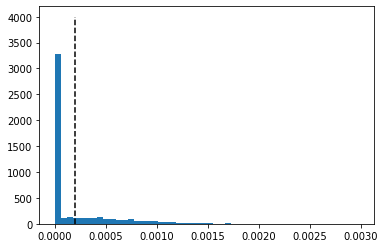

In [16]:
plt.hist(optweights/sum(optweights), bins=len(optweights)//100)
plt.vlines(x=1/len(optweights), ymin=0, ymax=4000, color='black', linestyles='dashed')

In [17]:
data_eca_study = data_eca.sample(config['nbase'], replace=True, weights=optweights, 
                             random_state=42)

Text(0.5, 0.98, 'Before (left) and after(right) Matching')

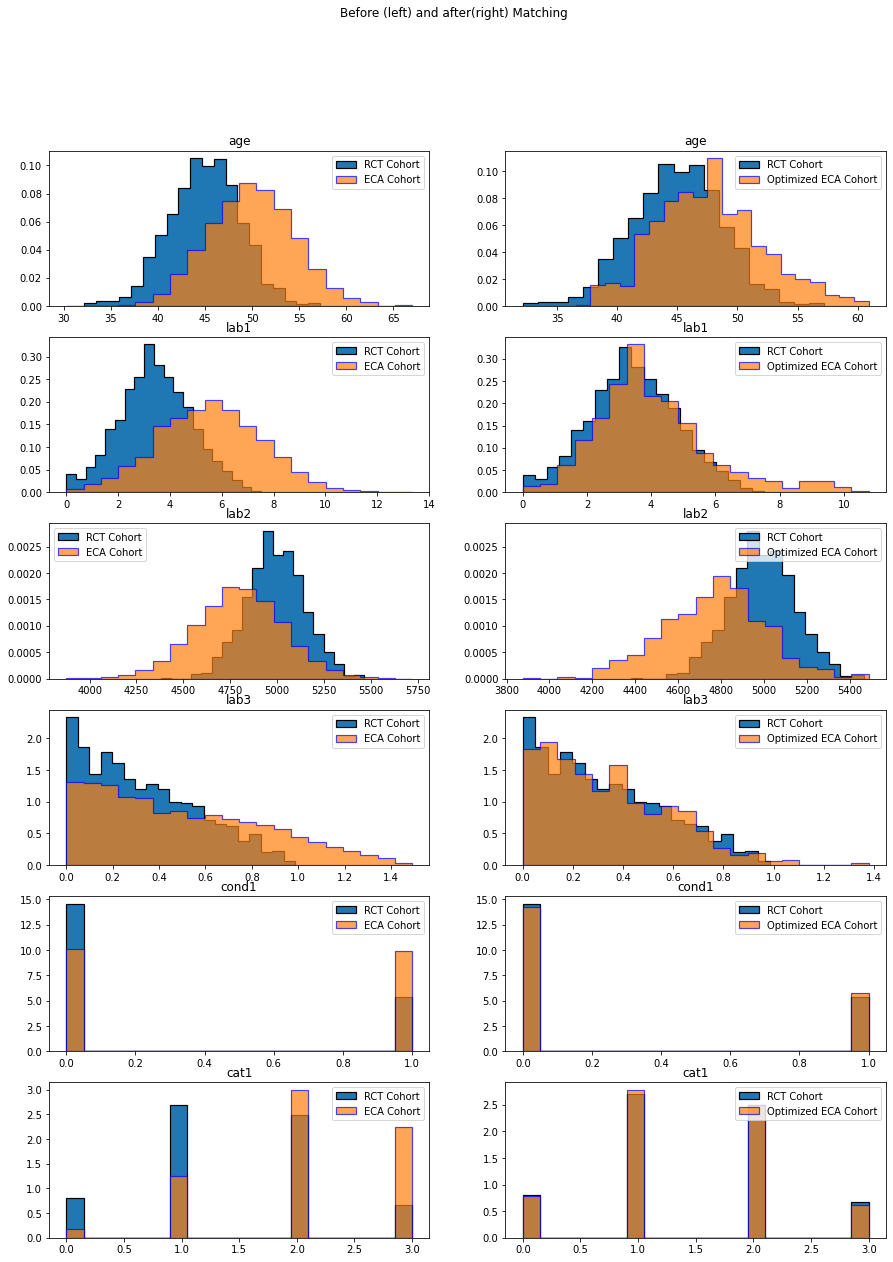

In [18]:
data_eca_study.name = 'Optimized ECA Cohort'

f, ax = plt.subplots(len(data_base.columns),2, figsize=(15, 20))

for i, col in enumerate(data_base.columns):
    plot_dist(data_base, data_eca, col, ax[i][0])
    plot_dist(data_base, data_eca_study, col, ax[i][1])

f.suptitle('Before (left) and after(right) Matching') 